In [1]:
import librosa
import numpy as np
from IPython.lib.display import Audio
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
%matplotlib inline

In [2]:
def invlogamplitude(S):
    '''librosa.logamplitude is actually 10*log10, so invert that.'''
    return 10.0 ** (S / 10.0)

### 载入wav

In [3]:
y,sr = librosa.load('happy.wav',sr=16000)
ipd.Audio(y, rate=sr)

### 计算MFCC

         win_len(窗长)
       ******************** (默认：2048)
0____1____2____3____4____5____6____  （数字代表每一帧，此时为“2”帧）

      ***** (默认：1/4 * win_len = 512)
      hop_len(窗移)

MFCC倒谱系数：[DTC_num,time_num]=[20,31]


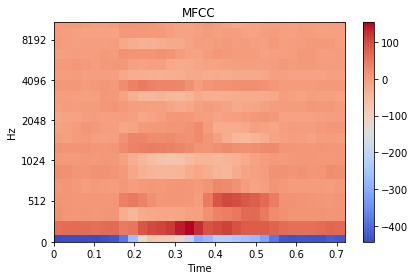

In [11]:
### MFCC #####
hop_length=512   #### 窗移长度（采样点数）
num_mfcc=20      #### MFCC数

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, hop_length=hop_length, n_fft=2048, n_mels=128) 
# If unspecified, defaults to ``win_length = n_fft``.
# **kwargs参数参考 librosa.stft；librosa.feature.melspectrogram；librosa.filters.mel;scipy.fftpack.dct

### MFCC-一二阶差分 ######
#delta_mfcc  = librosa.feature.delta(mfccs)
#delta2_mfcc = librosa.feature.delta(mfccs, order=2)
#mfccs = np.vstack([mfccs, delta_mfcc, delta2_mfcc])

print('MFCC倒谱系数：[DTC_num,time_num]=[%d,%d]' % mfccs.shape)

plt.figure(figsize=(6, 4))
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel')
plt.title('MFCC')
plt.colorbar()  #format='%+02.0f dB'
plt.tight_layout()

### 设置拟变换的相关矩阵（维度分别对齐）

DCT矩阵：[DTC_num,Mel_num]=[20,128]
Mel滤波器矩阵：[Mel_num,FFT_num]=[128,1025]


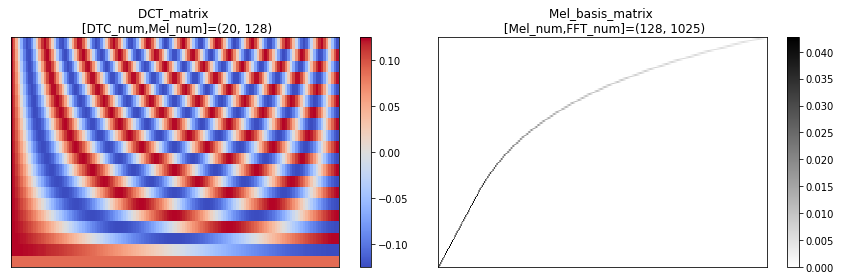

In [13]:
###### 拟MFCC 矩阵 设置 ########
n_mfcc = mfccs.shape[0] #will vary if deltas included

n_mel_recon = 128 # Mel滤波器组数
dctm = librosa.filters.dct(n_mfcc, n_mel_recon)
print('DCT矩阵：[DTC_num,Mel_num]=[%d,%d]' % dctm.shape)

n_fft_recon = 2048 # FFT长度（默认也等于窗长）
mel_basis = librosa.filters.mel(sr, n_fft_recon, n_mels=n_mel_recon)
print('Mel滤波器矩阵：[Mel_num,FFT_num]=[%d,%d]' % mel_basis.shape)

plt.figure(figsize=(12, 4))
plt.subplot(121)
librosa.display.specshow(dctm)
plt.title('DCT_matrix \n [DTC_num,Mel_num]='+str(dctm.shape))
plt.colorbar()

plt.subplot(122)
librosa.display.specshow(mel_basis,cmap='gray_r')
plt.title('Mel_basis_matrix \n [Mel_num,FFT_num]='+str(mel_basis.shape))
plt.colorbar()

plt.tight_layout()

### 逆变换开始

重构的频谱：[FFT_num,time_num]=[1025,31]


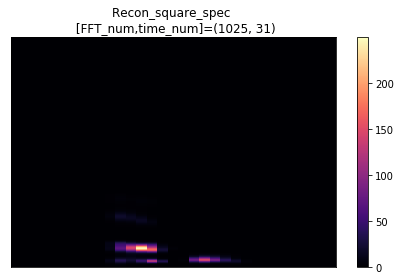

In [14]:
####### MFCC + noise ############
mfcc_noise = 0.0
noise = mfcc_noise*np.random.randn(mfccs.shape[0], mfccs.shape[1])
mfccs += noise

####### 功率谱近似 #######
#TODO: Figure out if should modify this
bin_scaling = 1.0 / np.maximum(0.01, np.sum(np.dot(mel_basis.T, mel_basis), axis=0))

recon_stft =  bin_scaling[:, np.newaxis] * np.dot(mel_basis.T, invlogamplitude(np.dot(dctm.T, mfccs)))
print('重构的频谱：[FFT_num,time_num]=[%d,%d]' % recon_stft.shape)

plt.figure(figsize=(6, 4))
librosa.display.specshow(recon_stft)
plt.title('Recon_square_spec \n [FFT_num,time_num]='+str(recon_stft.shape))
plt.colorbar() 
plt.tight_layout()

In [15]:
####### 重构语音 + noise （重构的语音会产生白噪声）#####
noise_scale = 0.0
noise = noise_scale * np.ones(recon_stft.shape)
recon_stft += noise

Excitation_length: (15360,)
Ori_wav: (15702,)


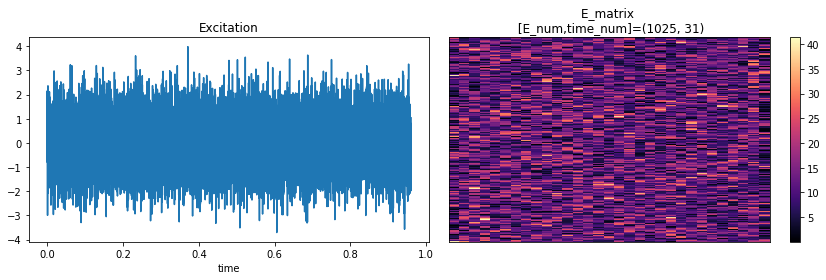

In [20]:
####### 构造相位（白噪声 + stft = real + i*image） ########
#excitation = np.random.randn(y.shape[0])
excitation =  np.random.randn(hop_length*(mfccs.shape[1]-1))

E = librosa.stft(excitation, hop_length=hop_length, n_fft=2048, win_length=512)

print("Excitation_length:",excitation.shape)
print("Ori_wav:",y.shape)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(np.arange(0, len(excitation))/sr, excitation)
plt.title('Excitation')
plt.xlabel("time") 

plt.subplot(122)
librosa.display.specshow(np.abs(E))
plt.title('E_matrix \n [E_num,time_num]='+str(E.shape))
plt.colorbar()

plt.tight_layout()

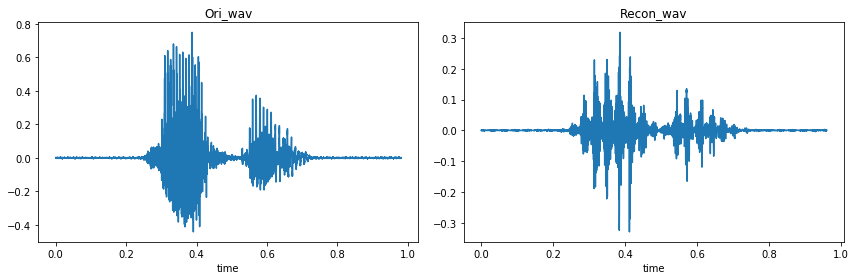

In [21]:
# Impose reconstructed magnitude on white noise STFT 
recon = librosa.istft(E / np.abs(E) * np.sqrt(recon_stft))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(np.arange(0, len(y))/sr, y)
plt.title('Ori_wav')
plt.xlabel("time")

plt.subplot(122)
plt.plot(np.arange(0, len(recon))/sr, recon)
plt.title('Recon_wav')
plt.xlabel("time") 

plt.tight_layout()
#### 重构语音 ####
ipd.Audio(recon, rate=sr)

In [10]:
##### 原始 ######
ipd.Audio(y, rate=sr)

In [ ]:
librosa.filters.mel()
librosa.stft()
librosa.feature.melspectrogram()